In [ ]:
## Turning handwriting to Latex.

## The code is heavily influenced by


### I
# A ten-minute-introduction-to-sequence-to-sequence-learning
# A encoder-decoder model for language translation
# URL: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html


### II

# Genthials blog post and paper Image to Latex,

# https://guillaumegenthial.github.io/image-to-latex.html



In [1]:
#Import Numpy, Tensorflow and Keras
import numpy as np
import tensorflow as tf
from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use

from keras.layers import Input, LSTM, Dense, Lambda, GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPooling2D, Reshape, Flatten
from keras import layers, backend ## IS THIS BEING USED?
from keras.models import Model
import keras.backend as K


# Import our own helper functions
from prepare_data import get_decoder_data
import load_data
import preprocess_image
from load_data import get_vocabulary_size, get_vocabulary
from convolutional_encoder import get_encoded

Using TensorFlow backend.


In [23]:
## Load and process data (currently only on a small subset)

encoder_input_data, target_texts = load_data.load_data()

target_tokens = get_vocabulary()


num_decoder_tokens = len(target_tokens)

max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model

print("Maximum output sequence lenght: " + str(max_decoder_seq_length))
print("Examples of sequences: ")
print("Ex. 1: " + str(target_texts[0]))
print("Ex. 1: " + str(target_texts[1]) + "\n")

print("Number of tokens in our vocabulary: " + str(num_decoder_tokens))
print("5 example of tokens: " + str(target_tokens[0:5]) + "\n")

print("Example pairs (token, index) in dictionary: ")

for i, key in enumerate(target_token_index):
    print(key, target_token_index[key])
    if i > 3:
        break

_, image_h, image_w, _  = encoder_input_data.shape


Getting max shape
Maximum output sequence lenght: 9
Examples of sequences: 
Ex. 1: **start** \alpha + \beta **end**
Ex. 1: **start** \frac { 1 } { 2 } **end**

Number of tokens in our vocabulary: 10
5 example of tokens: ['+', '1', '2', '\\alpha', '\\beta']

Example pairs (token, index) in dictionary: 
('\\frac', 5)
('\\beta', 4)
('+', 0)
('**end**', 9)
('**start**', 8)


In [34]:
# For forced teaching, we need decoder_input data and decoder target data. 
# Decoder target data is just decoder_input_data offset by one time step.

decoder_input_data, decoder_target_data = get_decoder_data(target_texts,
                                                            target_tokens,
														 	 num_decoder_tokens,
														 	  max_decoder_seq_length,
														 	   target_token_index)

print("Each row is a one-hot encoded token in the sequence.")
print("We have 10 columns because there are 10 tokens in our vocabulary")
print("We have 9 rows, because maximum output length is 9")
print("")

print("Decoder INPUT sequence example 1")
print(decoder_input_data[0]) #Each row is a one-hot encoded token in the sequence.
print("")
print("Decoder TARGET sequence example 1 (the same as above offset by one time step)")
print(decoder_target_data[0]) #Each row is a one-hot encoded token in the sequence.



Each row is a one-hot encoded token in the sequence.
We have 10 columns because there are 10 tokens in our vocabulary
We have 9 rows, because maximum output length is 9

Decoder INPUT sequence example 1
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

Decoder TARGET sequence example 1 (the same as above offset by one time step)
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.

Latex: **start** \alpha + \beta **end**


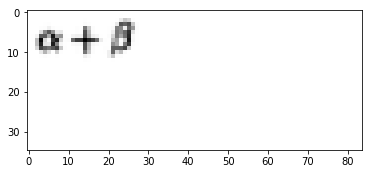

Latex: **start** \frac { 1 } { 2 } **end**


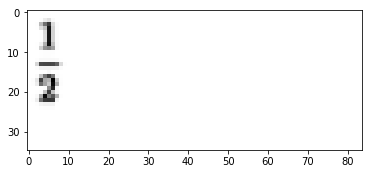

Latex: **start** \frac { \alpha } { \beta } **end**


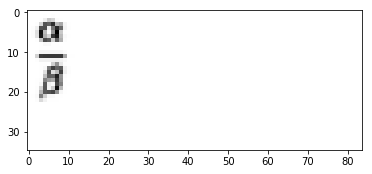

In [88]:
## Look at a few examples:

for i in range(3):

    print("Latex: " + (target_texts[i]))

    plt.imshow(encoder_input_data[i,:,:,0], cmap='gray')
    plt.show()

		sampled_token_index = np.argmax(output_tokens[0, -1, :])
		sampled_char = reverse_target_token_index[sampled_token_index]

In [1]:
def shuffle_data(X,Y, seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_samples = X.shape[0]
    p = np.random.permutation(num_samples)
    if len(X.shape) == 3:
        X = X[p,:,:]
    elif len(X.shape) == 4:
        X = X[p,:,:,:]
    Y = Y[p]
    
    return X,Y

In [94]:
## Function for debugging, going from a one_hot sequence of tokens, to the actual tokens


def from_one_hot_to_latex_sequence(one_hot_sequence):
    tokens = []
    for idx, token_vector in enumerate(one_hot_sequence):

        sampled_token_index = np.argmax(token_vector)
        sampled_char = reverse_target_token_index[sampled_token_index]

        tokens.append(sampled_char)
        if sampled_char == '**end**':
            break
    
    return tokens


latex_sequence_input = from_one_hot_to_latex_sequence(decoder_input_data[0])

latex_sequence_target = from_one_hot_to_latex_sequence(decoder_target_data[0])

print(latex_sequence_input)

print(latex_sequence_target)

['**start**', '\\alpha', '+', '\\beta', '**end**']
['\\alpha', '+', '\\beta', '**end**']


In [156]:
## Encoder step I: Encoding image into vectors (e1, e2, ..., en)

def get_encoded(image_h, image_w):

	encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image", dtype='float32')

    # Conv + max_pool / 2
	encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)
	encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    # Conv + max_pool /2
	encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    # 4 Conv
	encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(encoded)

	encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

	#encoded = time_signal()(encoded)

	encoded_shape = encoded.get_shape().as_list()
	_, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
	encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
	
	return encoder_inputs, encoded

In [157]:
## Encoder step II: transforming (e1, e2... en) to h0 and c0 (which will go into the decoder)

# Call convolutional encoder
encoder_inputs, encoded = get_encoded(image_h, image_w)

encoded_shape = encoded.get_shape().as_list()

#Compute the average e from encoding.

e_average = GlobalAveragePooling1D(name='average_e')(encoded)

#Compute h0 and c0, from e_average, following Genthial's suggestion
h0 = Dense(512, activation='tanh', name="h0")(e_average)
c0 = Dense(512, activation='tanh', name="c0")(e_average)

## h0, c0 are the outputs of the encoder

In [158]:
## Decoder. LSTM + Softmax layer

decoder_lstm_dim = 512

decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_lstm = LSTM(decoder_lstm_dim, 
					return_sequences=True, 
					return_state = True,
					name="decoder_lstm")

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_softmax')

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[h0, c0])
decoder_outputs = decoder_dense(decoder_outputs)

In [159]:
## Putting the training model together:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



In [ ]:
# Shuffle our data
shuffle_data(X,decoder_input_data, seed=100)

In [160]:
# Train and save the model

model.compile(optimizer='rmsprop', loss='categorical_crossentropy') # originally 'rmsprop'

epochs = 200
batch_size = 16

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
			batch_size=batch_size,
			epochs=epochs,
			validation_split=0.2, verbose=1)

Train on 8 samples, validate on 2 samples
Epoch 1/200
8/8 [==============================] - 2s 293ms/step - loss: 1.5313 - val_loss: 1.5698
Epoch 2/200
8/8 [==============================] - 1s 166ms/step - loss: 1.5624 - val_loss: 1.3072
Epoch 3/200
8/8 [==============================] - 1s 171ms/step - loss: 1.3189 - val_loss: 1.4052
Epoch 4/200
8/8 [==============================] - 1s 184ms/step - loss: 1.3240 - val_loss: 1.2322
Epoch 5/200
8/8 [==============================] - 1s 179ms/step - loss: 1.1763 - val_loss: 1.0583
Epoch 6/200
8/8 [==============================] - 1s 175ms/step - loss: 1.0955 - val_loss: 1.0544
Epoch 7/200
8/8 [==============================] - 1s 143ms/step - loss: 1.0509 - val_loss: 1.0818
Epoch 8/200
8/8 [==============================] - 1s 138ms/step - loss: 1.0717 - val_loss: 1.0619
Epoch 9/200
8/8 [==============================] - 1s 138ms/step - loss: 1.0646 - val_loss: 1.0082
Epoch 10/200
8/8 [==============================] - 1s 139ms/step -

Epoch 83/200
8/8 [==============================] - 1s 139ms/step - loss: 0.3051 - val_loss: 0.3194
Epoch 84/200
8/8 [==============================] - 1s 136ms/step - loss: 0.3125 - val_loss: 0.3068
Epoch 85/200
8/8 [==============================] - 1s 137ms/step - loss: 0.3178 - val_loss: 0.3200
Epoch 86/200
8/8 [==============================] - 1s 138ms/step - loss: 0.3189 - val_loss: 0.2932
Epoch 87/200
8/8 [==============================] - 1s 137ms/step - loss: 0.3013 - val_loss: 0.2965
Epoch 88/200
8/8 [==============================] - 1s 137ms/step - loss: 0.2935 - val_loss: 0.2786
Epoch 89/200
8/8 [==============================] - 1s 136ms/step - loss: 0.2878 - val_loss: 0.2973
Epoch 90/200
8/8 [==============================] - 1s 137ms/step - loss: 0.2944 - val_loss: 0.2984
Epoch 91/200
8/8 [==============================] - 1s 138ms/step - loss: 0.3169 - val_loss: 0.4152
Epoch 92/200
8/8 [==============================] - 1s 137ms/step - loss: 0.4245 - val_loss: 0.5282


Epoch 165/200
8/8 [==============================] - 1s 186ms/step - loss: 0.1668 - val_loss: 0.1842
Epoch 166/200
8/8 [==============================] - 1s 185ms/step - loss: 0.1667 - val_loss: 0.1488
Epoch 167/200
8/8 [==============================] - 1s 172ms/step - loss: 0.1660 - val_loss: 0.1844
Epoch 168/200
8/8 [==============================] - 1s 140ms/step - loss: 0.1654 - val_loss: 0.1464
Epoch 169/200
8/8 [==============================] - 1s 140ms/step - loss: 0.1649 - val_loss: 0.1840
Epoch 170/200
8/8 [==============================] - 1s 139ms/step - loss: 0.1646 - val_loss: 0.1455
Epoch 171/200
8/8 [==============================] - 1s 139ms/step - loss: 0.1643 - val_loss: 0.1829
Epoch 172/200
8/8 [==============================] - 1s 140ms/step - loss: 0.1641 - val_loss: 0.1460
Epoch 173/200
8/8 [==============================] - 1s 141ms/step - loss: 0.1637 - val_loss: 0.1805
Epoch 174/200
8/8 [==============================] - 1s 139ms/step - loss: 0.1634 - val_los

In [161]:
# Save the model and show summary

model.save('s2s.h5')

print("Encoder / decoder model training: ")
model.summary()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/keras/engine/topology.py:2344: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'h0_3/Tanh:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'c0_3/Tanh:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Encoder / decoder model training: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_image (InputLayer (None, 35, 84, 1)    0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 35, 84, 64)   640         encoder_input_image[0][0]        
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 18, 42, 64)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 18, 42, 128)  73856       max_pooling2d_9[0][0]            
__________________________________________________________________________

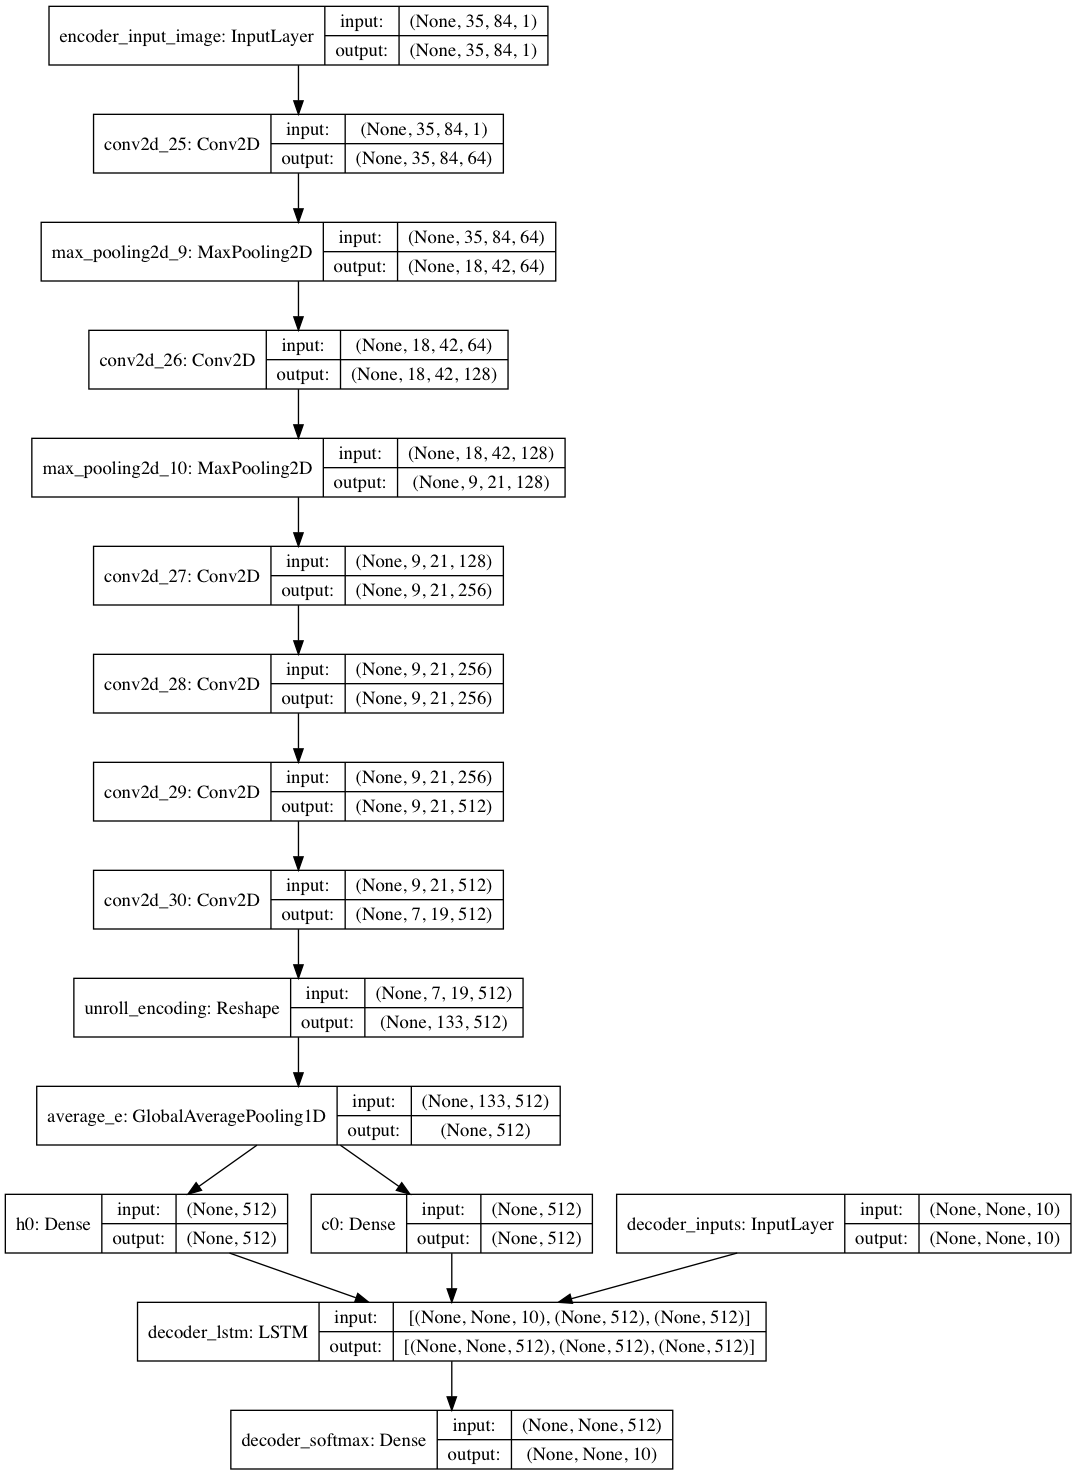

In [162]:
## Visualize the training model

from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='training_model.png', show_shapes=True)

Image(filename='training_model.png') 


In [171]:
### Time for inference


# Step 1. Set up the encoder as a separate model:

encoder_model = Model(encoder_inputs, [h0, c0, encoded, e_average]) #encoded and e_average are included for debugging purposes


In [172]:
# Step 2. Set up the decoder as a separate model.

# The decoder takes three inputs: the input_state_h, input_state_c and 

latent_dim = 512
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Will be a one-hot encoded vector
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [173]:
## Plot the inference Encoder Model 
plot_model(encoder_model, to_file='inference_encoder_model.png', show_shapes=True)

## Uncomment for plotting
#Image(filename='inference_encoder_model.png') 



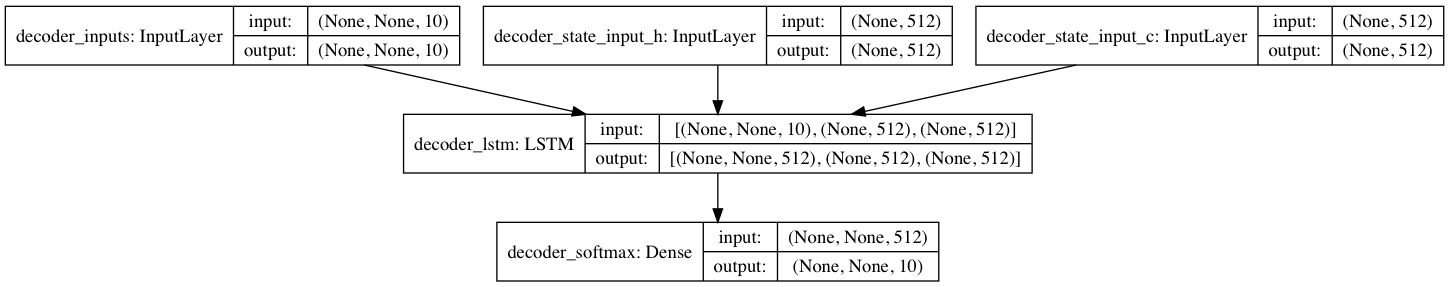

In [174]:
## Plot the inference Decoder model
plot_model(decoder_model, to_file='inference_decoder_model.png', show_shapes=True)
Image(filename='inference_decoder_model.png') 


In [182]:
## Decode sequence using our two models

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    hidden_0, memory_0, encoded_image, e_average = encoder_model.predict(input_seq)

    #print("Hidden 0 shape")
    #print(hidden_0.shape)
    
    #print("E_average shape")
    #print(e_average.shape)
    
    #print("Printing e_average")
    #print(e_average)
    
    #print("Hidden 0")
    
    #print(hidden_0)
    #print("Printing encoded")
    #print(encoded_image)
    
    
    
    states_value = [hidden_0, memory_0]

    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['**start**']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        #print(target_seq)
        output_tokens, h, c = decoder_model.predict(
        [target_seq] + states_value)

        # Sample a token
        #print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence = decoded_sentence + ' ' + sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '**end**' or
            len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence, encoded_image


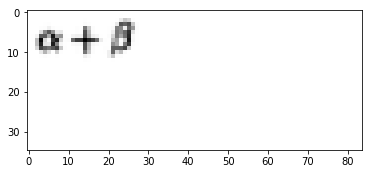

-
Target sentence: **start** \alpha + \beta **end**
Decoded sentence:  \frac { \alpha } { \beta } **end**


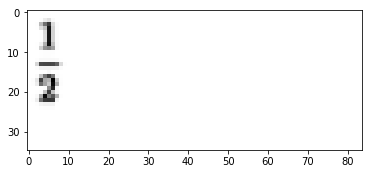

-
Target sentence: **start** \frac { 1 } { 2 } **end**
Decoded sentence:  \frac { \alpha } { \beta } **end**


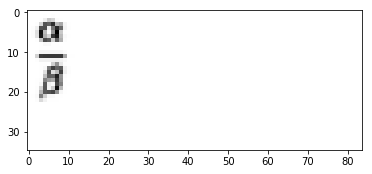

-
Target sentence: **start** \frac { \alpha } { \beta } **end**
Decoded sentence:  \frac { \alpha } { \beta } **end**


In [184]:
num_test = 3

encoded_images = []

for seq_index in range(num_test):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]

    plt.imshow(np.squeeze(input_seq), cmap='gray')
    plt.show()
    
    decoded_sentence, encoded_image = decode_sequence(input_seq)
    
    encoded_images.append(str(encoded))
    print('-')
    print('Target sentence: ' + str(target_texts[seq_index]))
    print('Decoded sentence: ' + str(decoded_sentence))

In [185]:
print(encoded_images[0])

Tensor("unroll_encoding_4/Reshape:0", shape=(?, 133, 512), dtype=float32)
